In [2]:
from music21 import converter, instrument, stream, analysis, midi, stream, note, chord, clef
from LBDM import calculateStrengths, extractPhrases
from entropy import streamEntropy
from plots import plotBoundaryStrength
import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import pandas as pd

identifier = "beethoven-op67"
path = f"../Pickles/{identifier}/{identifier}_"

score = converter.parse(path + "score.musicxml")
phrases = pd.read_csv(path + "phrases.csv", index_col=[0,1])
G = nx.read_graphml(path + "graph.graphml")

10


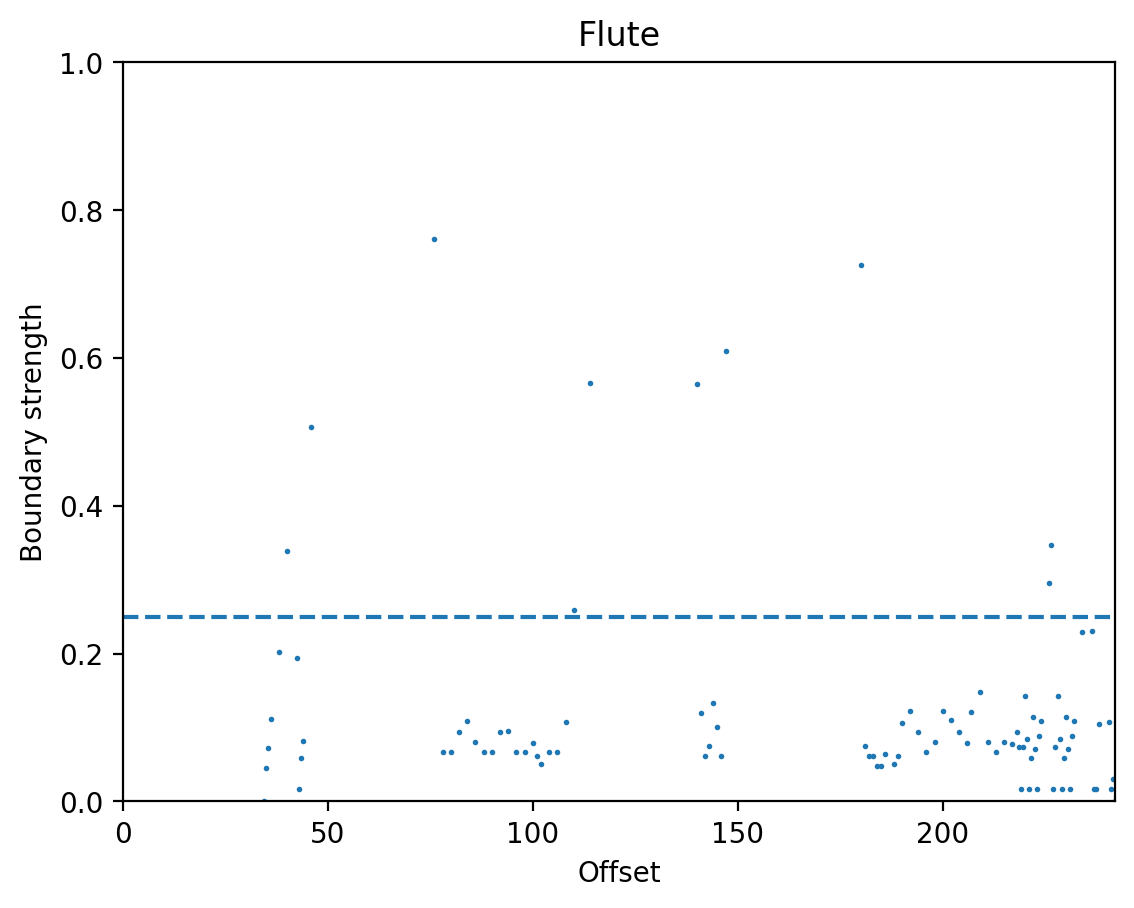

10


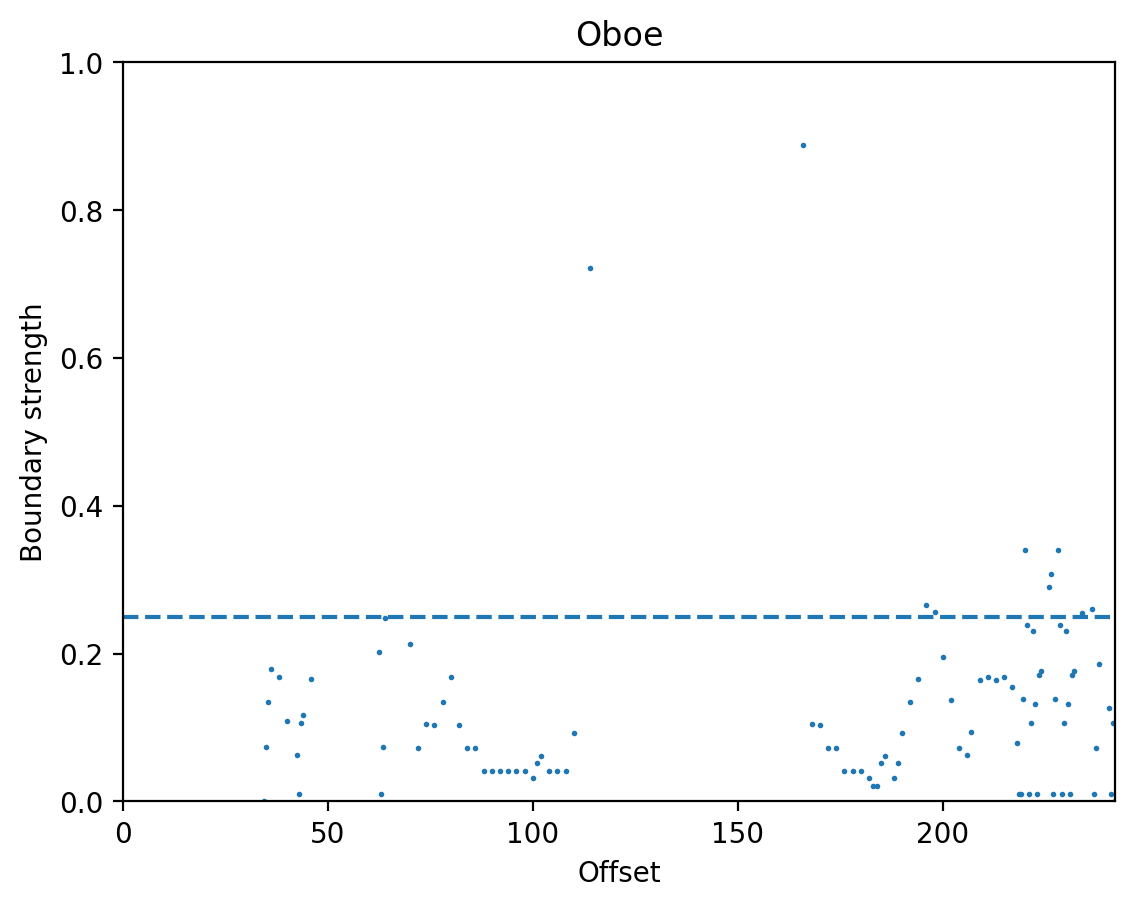

23


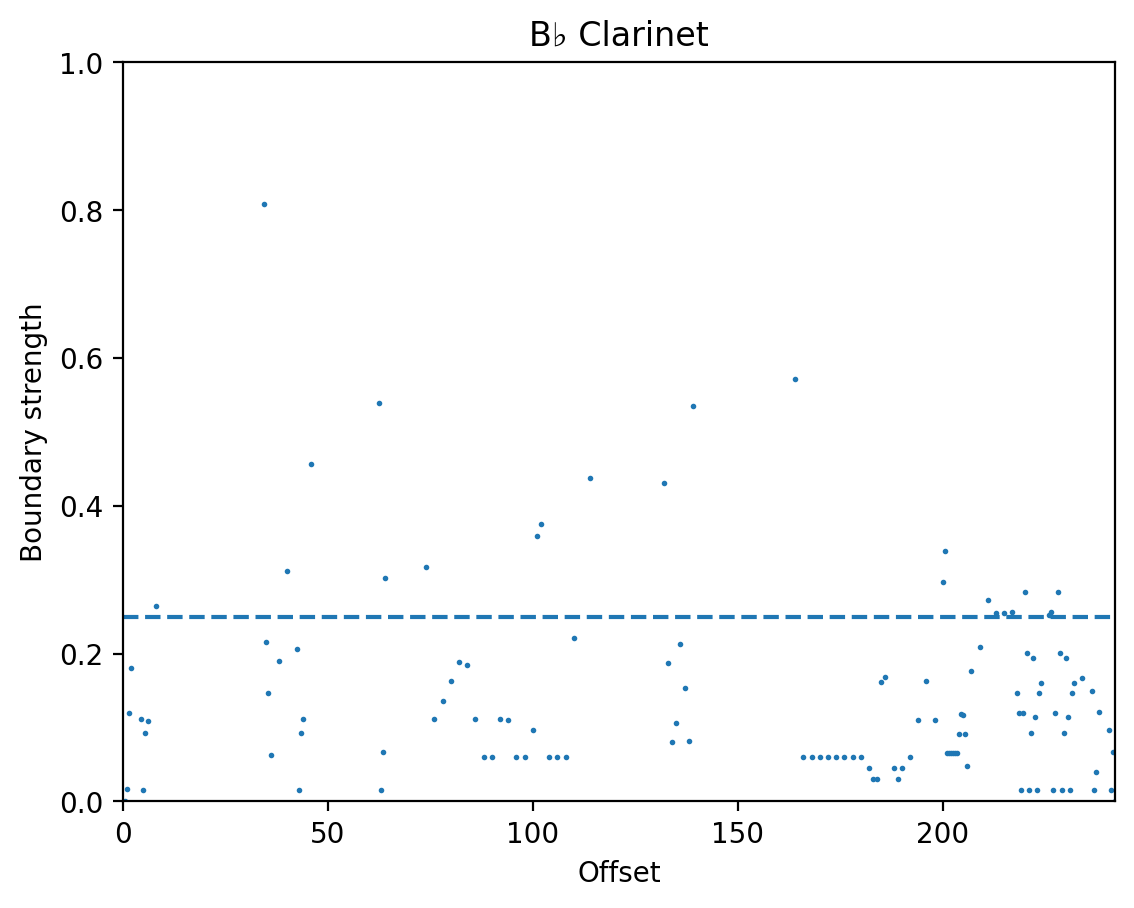

12


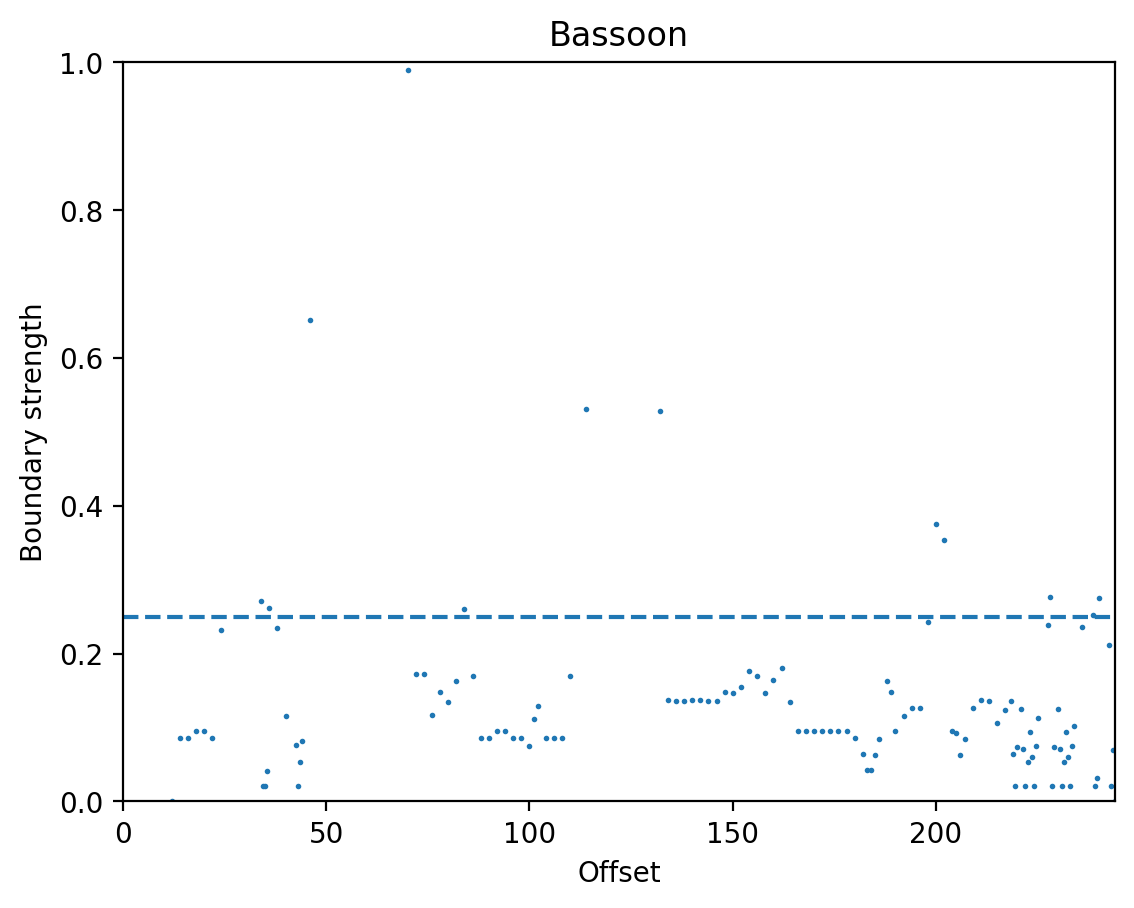

26


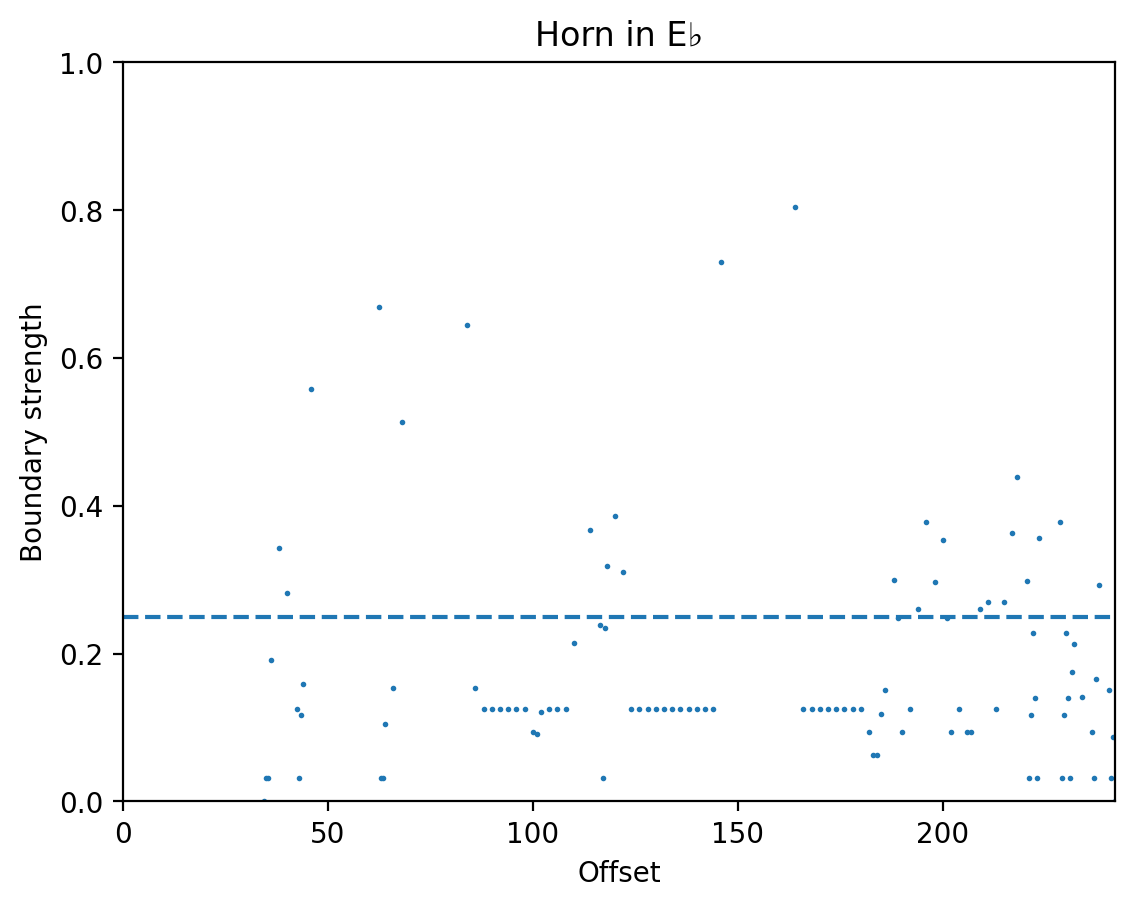

9


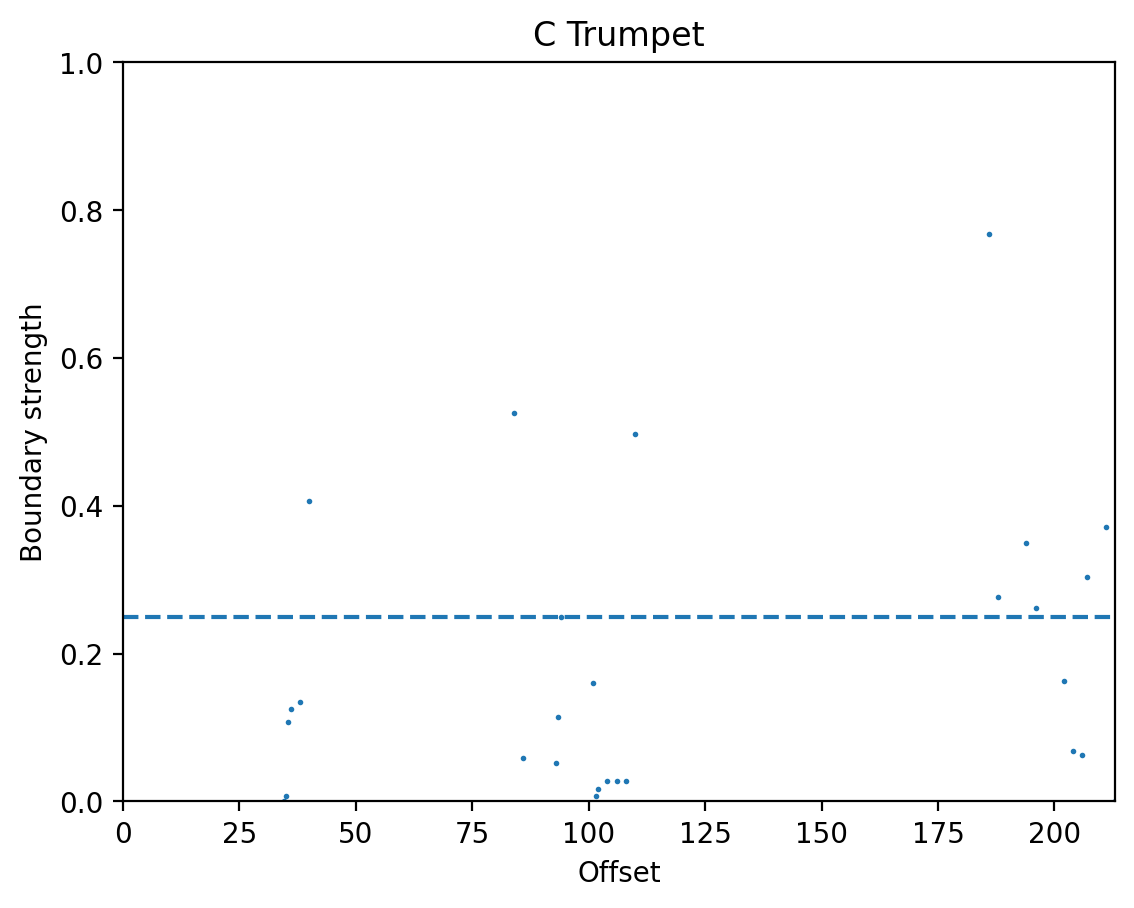

6


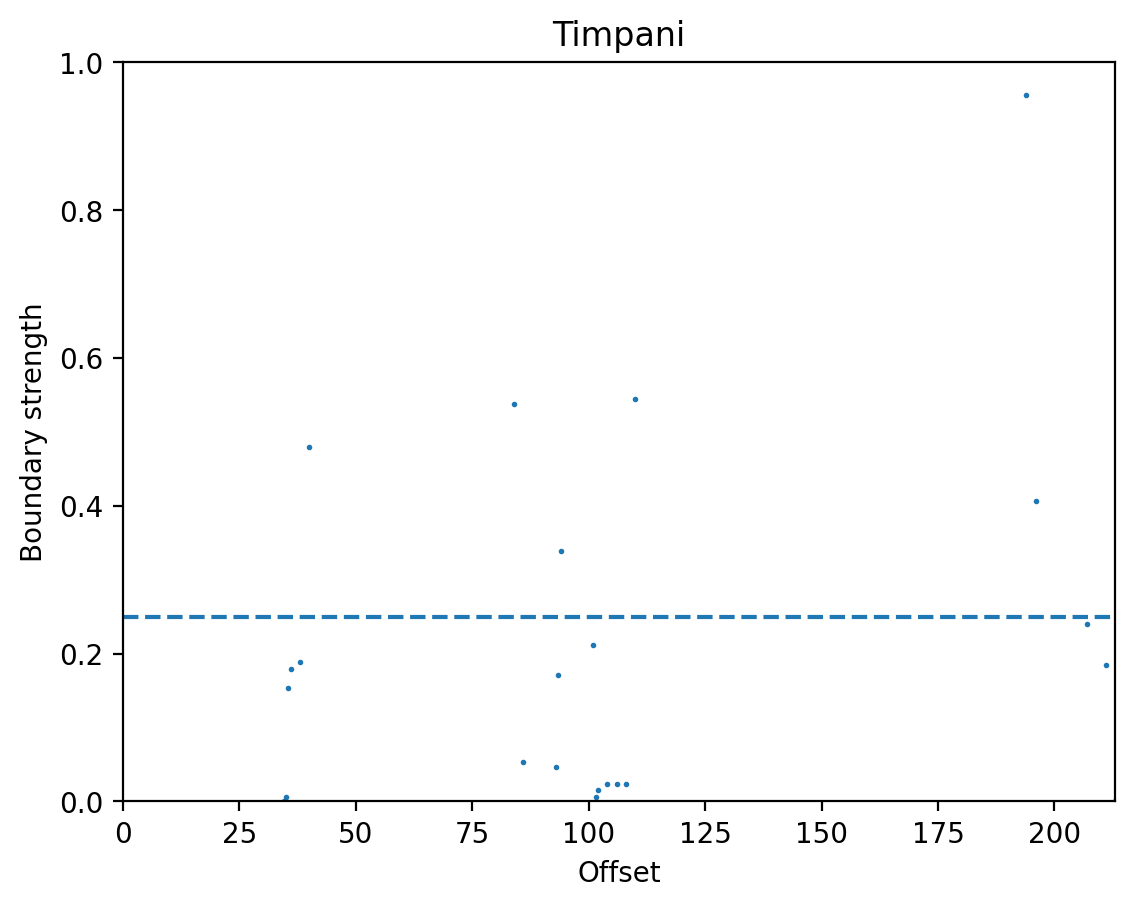

16


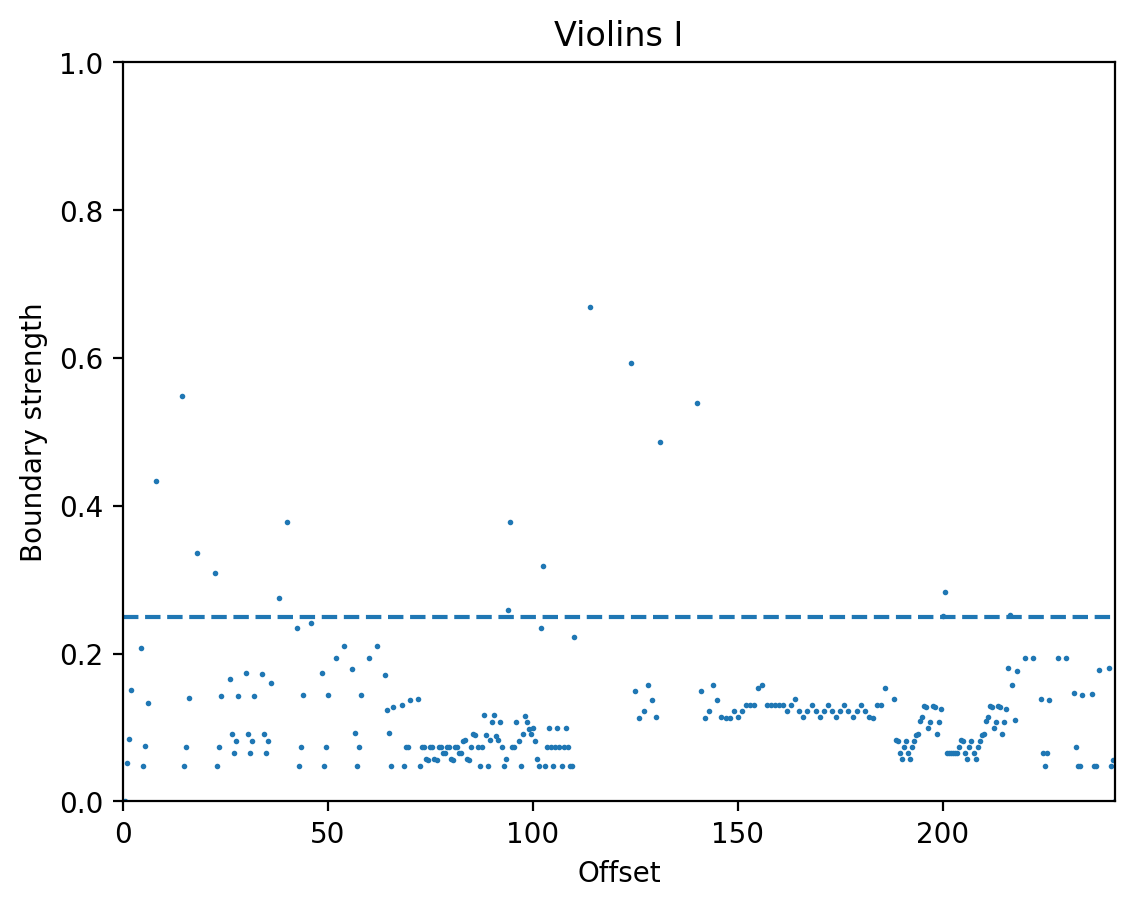

24


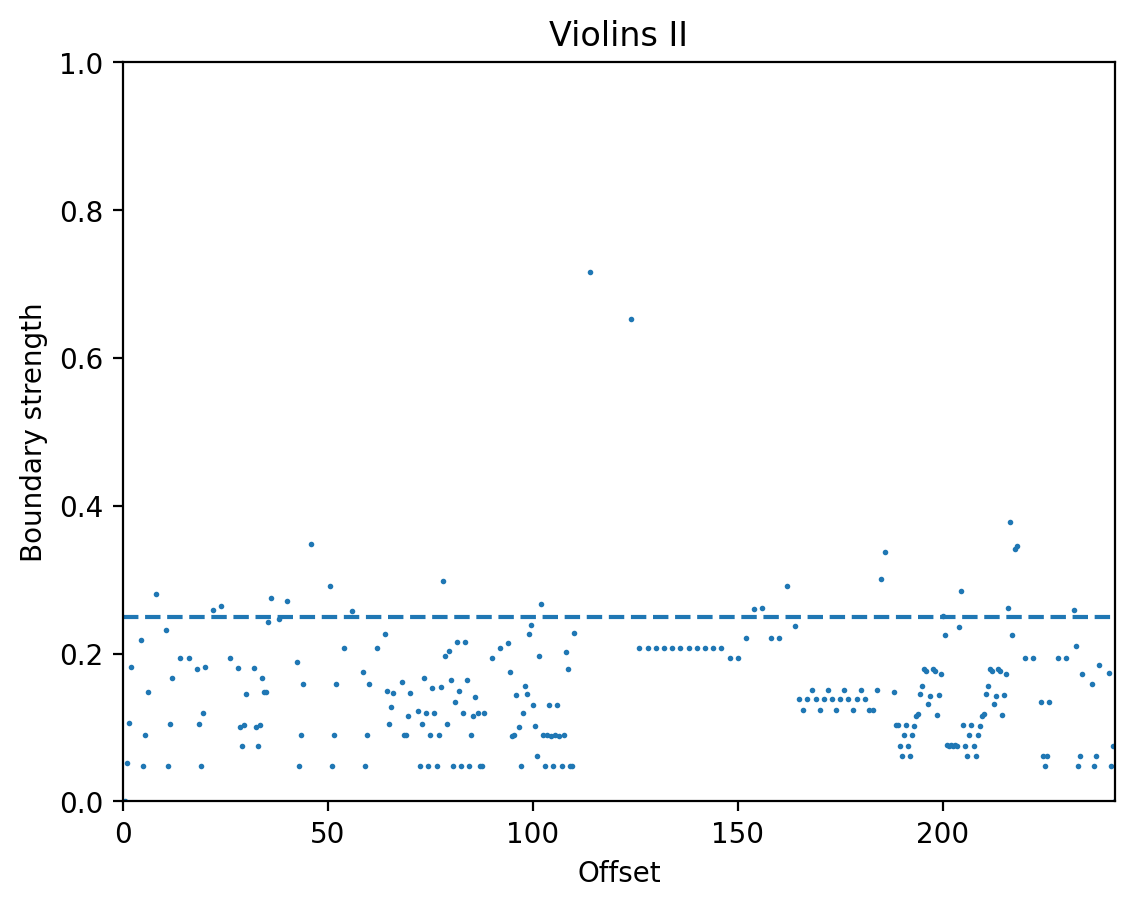

26


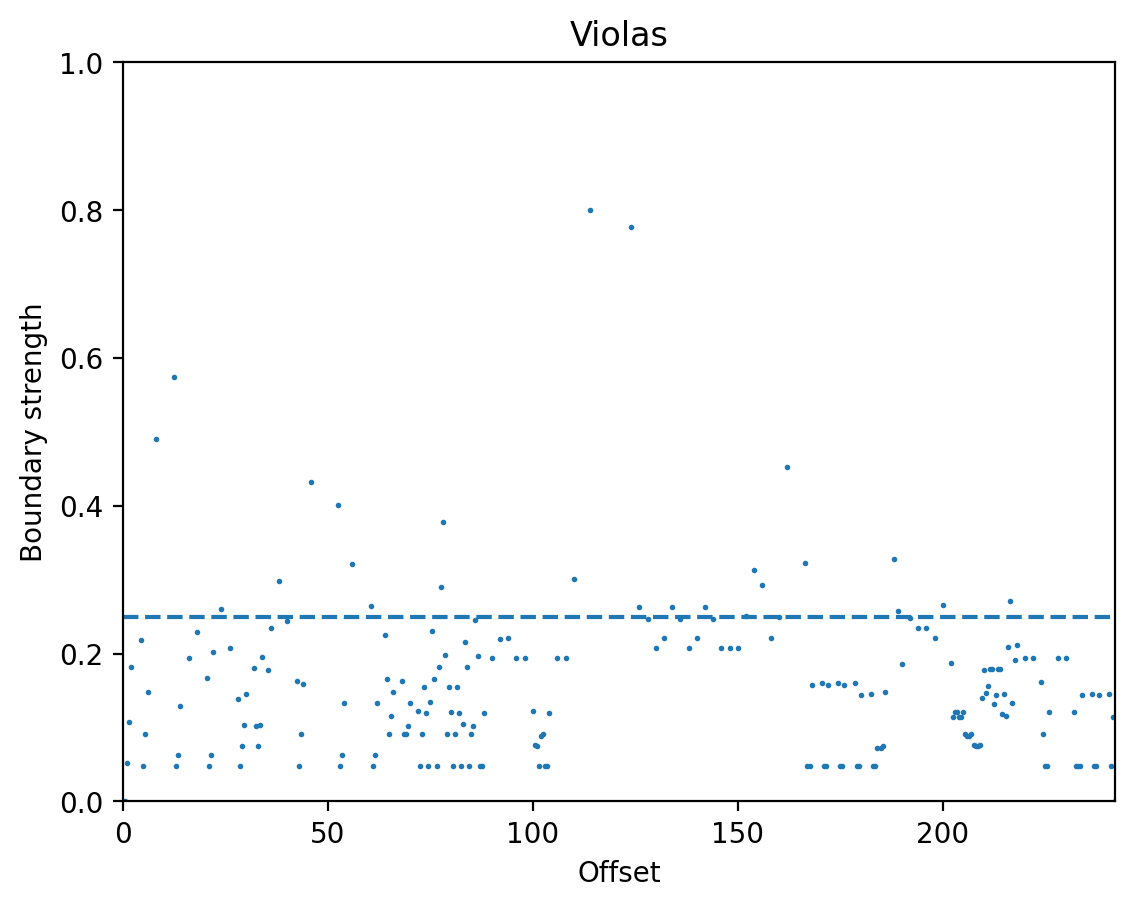

25


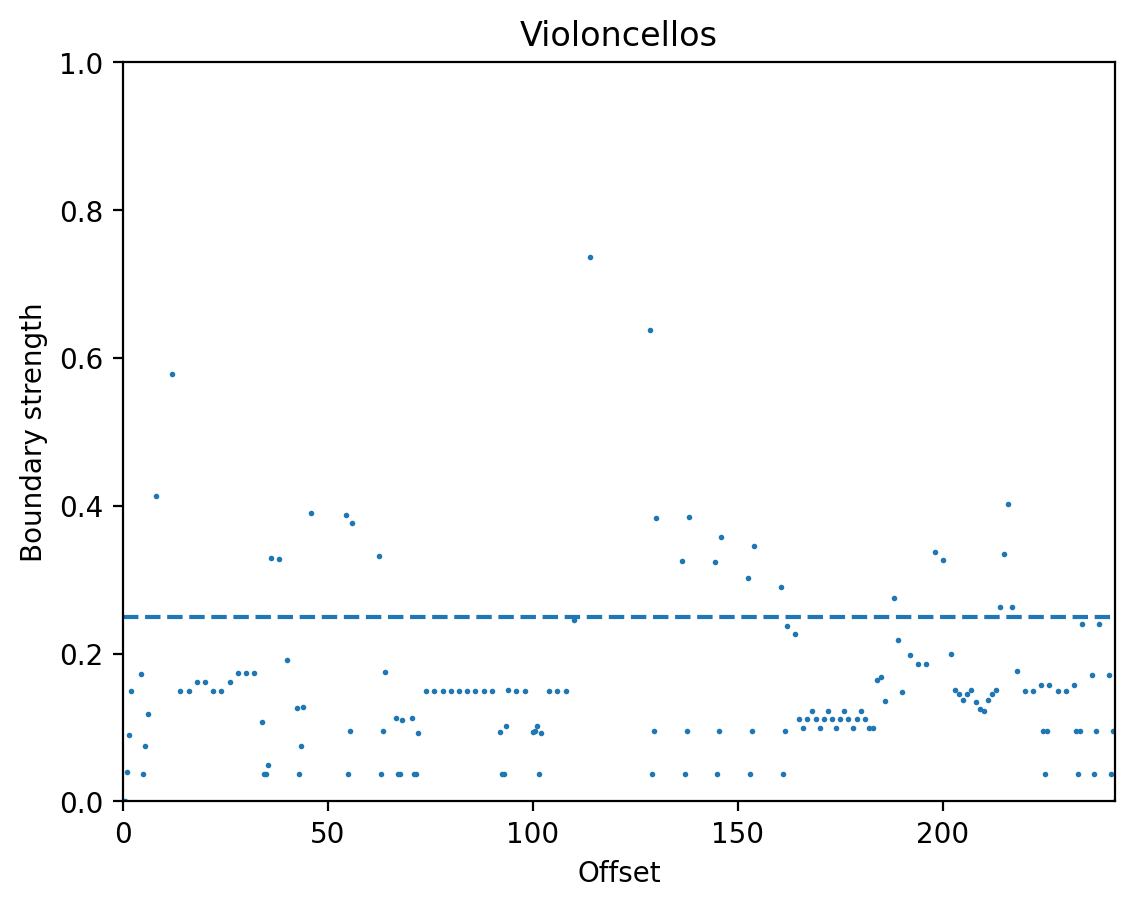

6


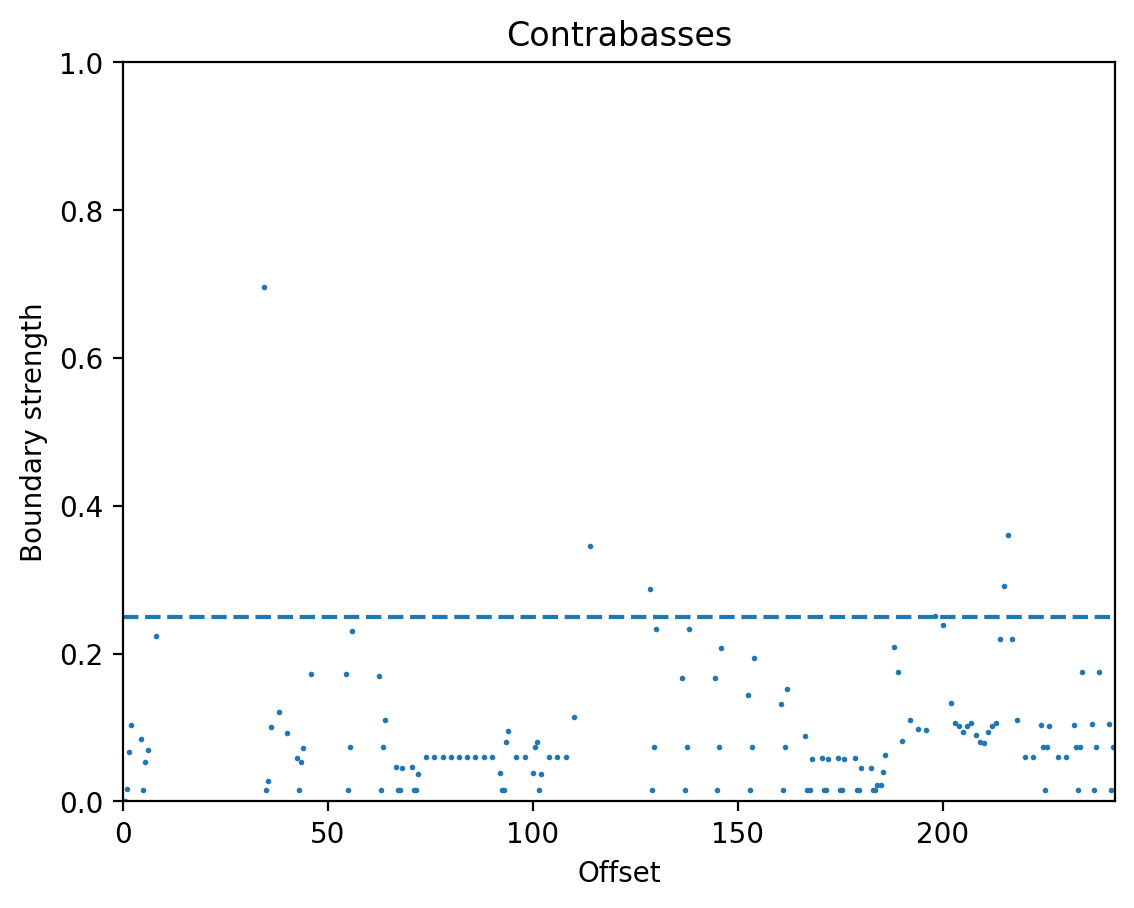

193


In [7]:
count = 0

for part in score.parts:

    df, thresh = calculateStrengths(part, .25, (0.33, 0.66))
    plotBoundaryStrength(df, thresh)
    plt.title(part.id)
    
    boundaries = len(df.query("IsBoundary"))
    print(boundaries)
    count += boundaries
    plt.show()

print(count)

In [16]:
#score.measures(1, 124).show()
score.measures(1, 124).write(fmt="musicxml", fp="condensed")

WindowsPath('c:/Users/Lucas/OneDrive - Durham University/PHYS4213/Code/condensed.musicxml')

In [22]:
score.write(fmt="musicxml", fp="no-chords")

WindowsPath('c:/Users/Lucas/OneDrive - Durham University/PHYS4213/Code/no-chords.musicxml')

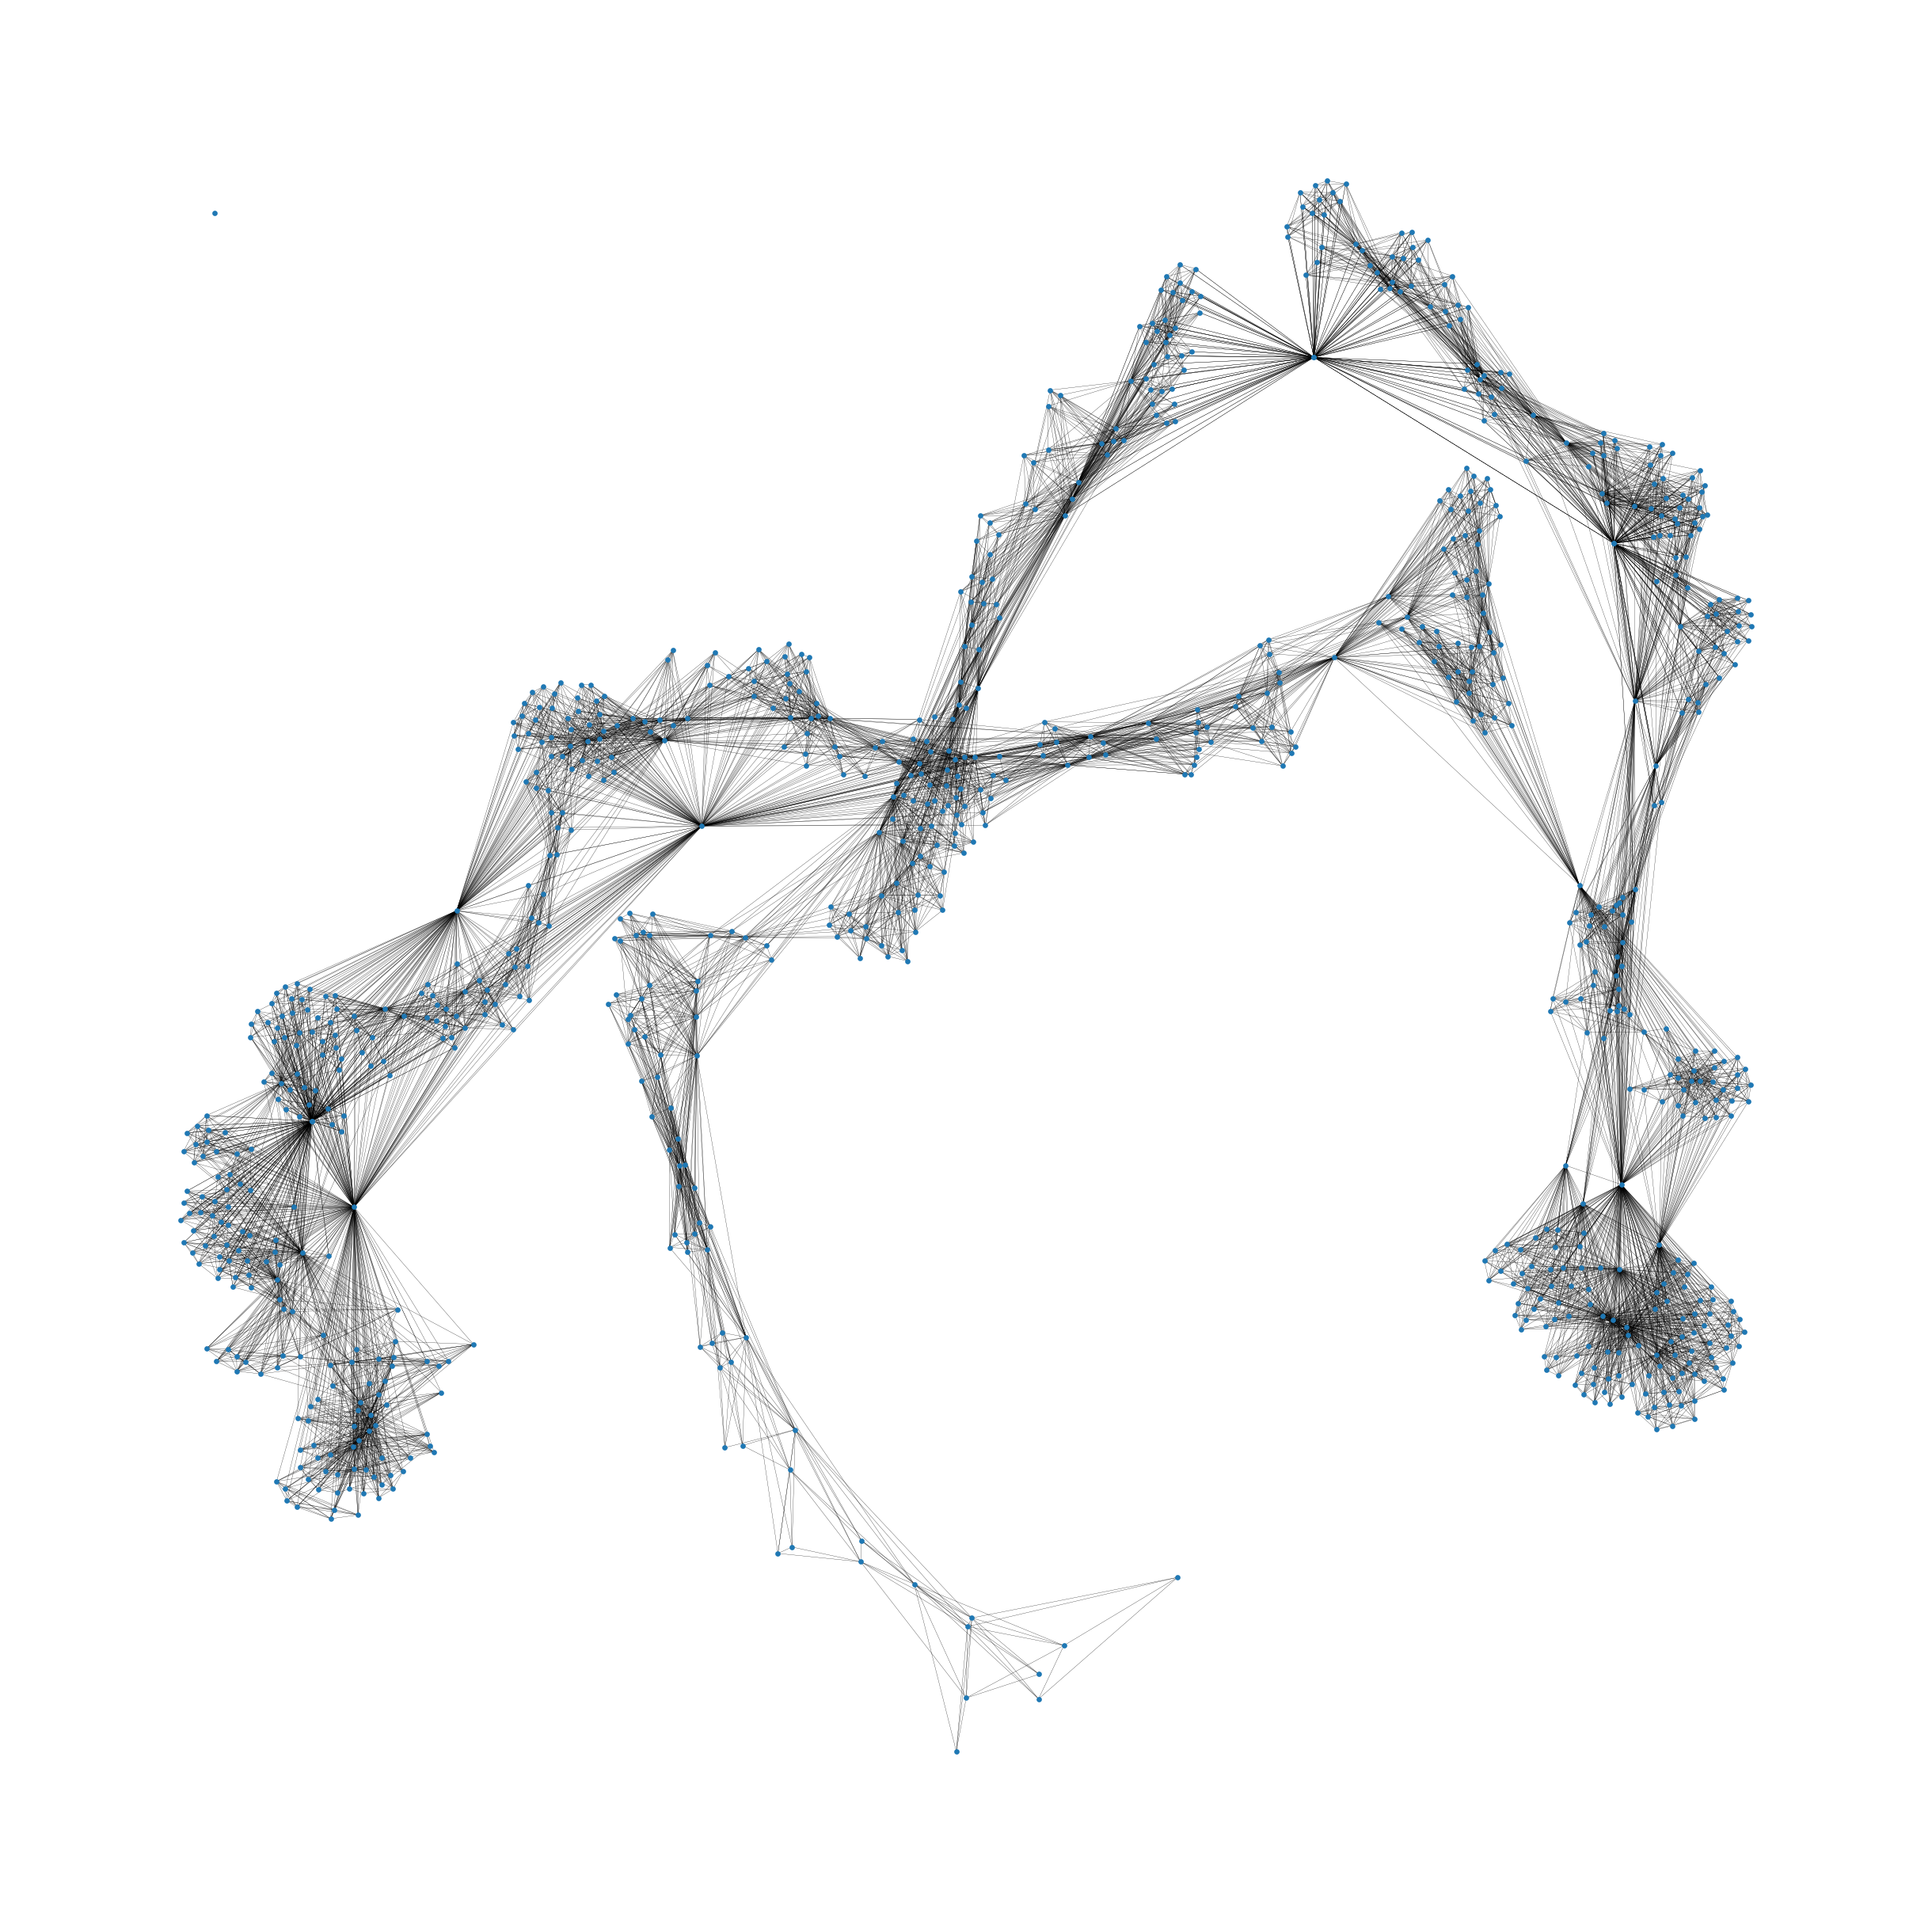

In [ ]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, weight="entropy", k=.1)
nx.draw(G, pos=pos, node_size=2, width=.1)

In [4]:
import itertools as iter

print(len(phrases))

#print(phrases.index.unique(0))

print([i for i in phrases.index])
#print(phrases["Start"])
print(phrases.loc[("Flute", 1), "Entropy"])


#for inst, new_df in phrases.groupby(level=0, sort=False):
    #print(inst)
    #print(new_df.index.get_level_values(1))


935
[('Flute', 1), ('Flute', 2), ('Flute', 3), ('Flute', 4), ('Flute', 5), ('Flute', 6), ('Flute', 7), ('Flute', 8), ('Flute', 9), ('Flute', 10), ('Flute', 11), ('Flute', 12), ('Flute', 13), ('Flute', 14), ('Flute', 15), ('Flute', 16), ('Flute', 17), ('Flute', 18), ('Flute', 19), ('Flute', 20), ('Flute', 21), ('Flute', 22), ('Flute', 23), ('Flute', 24), ('Flute', 25), ('Flute', 26), ('Flute', 27), ('Flute', 28), ('Flute', 29), ('Flute', 30), ('Flute', 31), ('Flute', 32), ('Oboe', 1), ('Oboe', 2), ('Oboe', 3), ('Oboe', 4), ('Oboe', 5), ('Oboe', 6), ('Oboe', 7), ('Oboe', 8), ('Oboe', 9), ('Oboe', 10), ('Oboe', 11), ('Oboe', 12), ('Oboe', 13), ('Oboe', 14), ('Oboe', 15), ('Oboe', 16), ('Oboe', 17), ('Oboe', 18), ('Oboe', 19), ('Oboe', 20), ('Oboe', 21), ('Oboe', 22), ('Clarinet', 1), ('Clarinet', 2), ('Clarinet', 3), ('Clarinet', 4), ('Clarinet', 5), ('Clarinet', 6), ('Clarinet', 7), ('Clarinet', 8), ('Clarinet', 9), ('Clarinet', 10), ('Clarinet', 11), ('Clarinet', 12), ('Clarinet', 13), 

   Pitch  Offset  Pitch strength  Offset strength  Strength  IsBoundary
0   43.0     0.5        0.000000         0.000000  0.000000       False
0   43.0     1.0        0.000000         0.048227  0.031830       False
0   43.0     1.5        0.139837         0.046505  0.076839       False
0   39.0     2.0        0.191829         0.095394  0.126264       False
0   41.0     4.5        0.068333         0.177922  0.139979       False


Text(0, 0.5, 'Boundary strength')

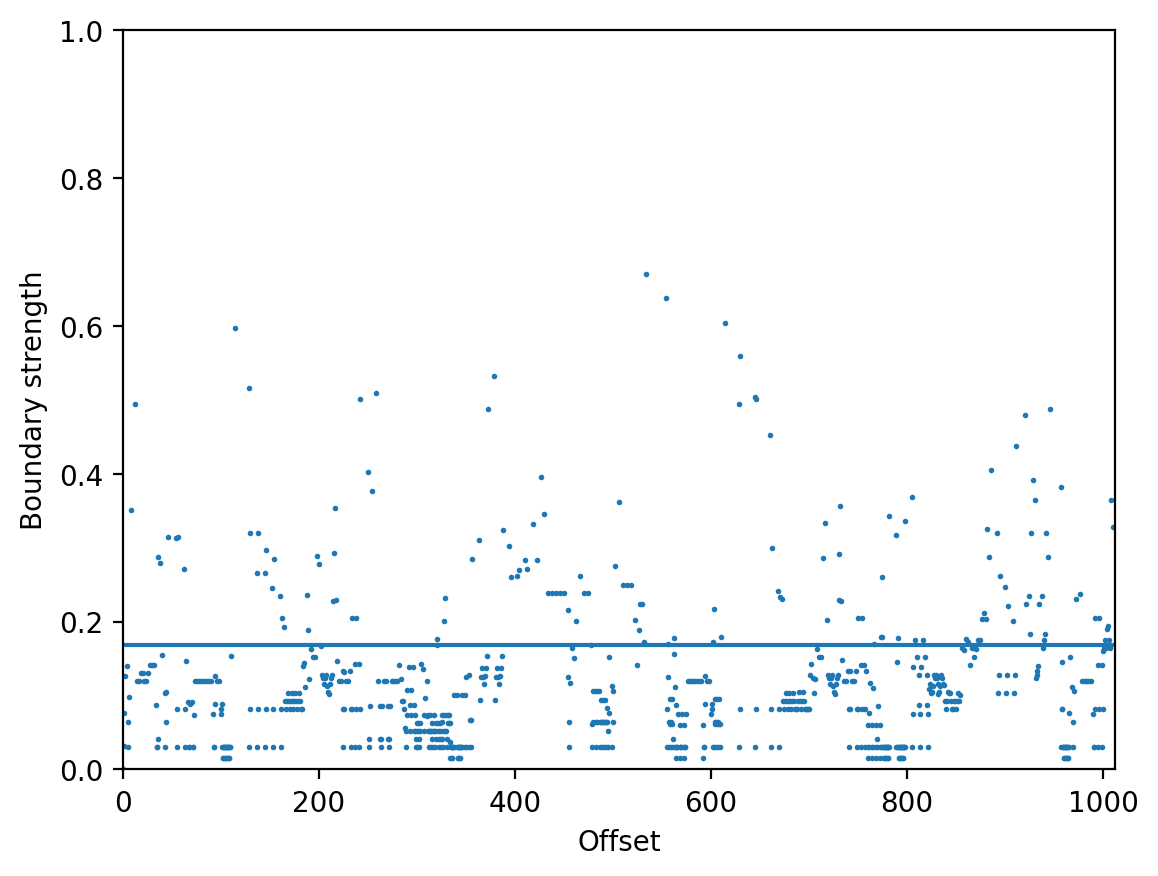

In [ ]:
#score = converter.parse(path + "score.musicxml")

df, threshold = calculateStrengths(score.parts[-2], (0.33,0.66))

#saveToMidi(score, "../67-edited.mid")
#score.write(fmt="musicxml", fp=f"../beethoven-op67.musicxml")

# TODO: Check what MIDI sounds like after arrangement (transposing instruments etc.)

In [ ]:
# TODO: Save phrases within a stream (instead of pickle)

bassoon = instrument.Bassoon()
print(bassoon.lowestNote.ps, bassoon.highestNote)

toy = converter.parse("tinyNotation: 4/4 r8 d' d' d' g' a' b' a' g2 r")

def shiftOctave(s: stream.Stream, o: int):
    for n in s.recurse().notes:
        n.octave += o

p = analysis.discrete.Ambitus()
pitchMin, pitchMax = p.getPitchSpan(toy)
print(pitchMin)

shiftOctave(toy, -2)
toy.show()

sp = midi.realtime.StreamPlayer(toy)
sp.play()

print(pitchMin)

In [22]:
score.write(fmt="musicxml", fp=f"../raiders")

musicxml.m21ToXml: WARNING: we are out of midi channels! help!


WindowsPath('c:/Users/Lucas/OneDrive - Durham University/PHYS4213/raiders.musicxml')

In [ ]:
score = converter.parse("../Pickles/Beethoven/Beethoven_score.musicxml")
#saveToMidi(score, "../Pickles/Beethoven/beethoven.mid")

new = stream.Score()

for part in score.parts:

    print(part.partName)
    part.atSoundingPitch = True
    print(part.atSoundingPitch)

    voices = part.voicesToParts()
    print(len(voices.parts))
    if len(voices.parts) > 1:
        part = part.voicesToParts().parts[0]

    new.append(part)

new.measures(1,7).show()
saveToMidi(new, "../Pickles/Beethoven/sounding_pitch.mid")
#new.write(fmt="musicxml", fp=f"../Pickles/Beethoven/beethoven.musicxml")